# Web Scrapping
*[Cyril Pecoraro](http://github.com/cyril-p)*

**Scrapping Data from the Web**

In this project we will extract interesting information from IS-Academia, the educational portal of EPFL. Specifically, we will focus on the part that allows public access to academic [data](http://isa.epfl.ch/imoniteur_ISAP/%21gedpublicreports.htm?ww_i_reportmodel=133685247). 


We will obtain all the data for the "informatique" Bachelor students, starting from 2007. We will keep only the students for which we have an entry for both Bachelor semestre 1 and Bachelor semestre 6. We will compute how many months it took each student to go from the first to the sixth semester. We will partition the data between male and female students, and compute the average and find if the difference in average is statistically significant?

In [1]:
import requests 
import pandas as pd
from scipy import stats
import urllib3
% matplotlib inline
from bs4 import BeautifulSoup

We have a BaseFormUrl, and from there, we will get the tags for the type of results, and every choice in the menu on the left of the page.

The idea is to hardcode the name of the parameters and get their possible values. 
Parameters are : 
'ww_i_reportModelXsl','ww_x_UNITE_ACAD','ww_x_PERIODE_ACAD','ww_x_PERIODE_PEDAGO','ww_x_HIVERETE'

In [2]:
# We define two url: One for selecting the parameters, one for displaying the student names.
baseFormUrl = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247'
baseFormUrlDisplay = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.bhtml?ww_b_list=1&ww_i_reportmodel=133685247'

r = requests.get(baseFormUrl)
soup = BeautifulSoup(r.content, "html.parser")

The idea is to put all the params needed and their possible values in a nested dictionary named 'ww_params'

Select the format of the page in table which has tag 'format'. Data is available in html or XLS. We use Html.

In [3]:
ww_params = dict()
formatTable = soup.find('table',attrs={'id': 'format'})
try:
    value = formatTable.findAll('input', attrs={'name':"ww_i_reportModelXsl"})
except:
    pass
value_ww_i_reportModelXsl = value[0]['value']
ww_params["ww_i_reportModelXsl"] = value_ww_i_reportModelXsl

We get the possible values for the parameters 'ww_i_reportModelXsl','ww_x_UNITE_ACAD','ww_x_PERIODE_ACAD','ww_x_PERIODE_PEDAGO','ww_x_HIVERETE'.

In [4]:
filtreName = ['ww_x_UNITE_ACAD','ww_x_PERIODE_ACAD','ww_x_PERIODE_PEDAGO','ww_x_HIVERETE']
filtreTable = soup.find('table',attrs={'id': 'filtre'})

for name in filtreName:
    ww_paramsList = dict()
    academicChoice = filtreTable.find('select',attrs={'name': name})
    value_ww_x_UNITE_ACAD = []
    try:
        choice = academicChoice.findAll('option')
    except:
        print('error')
        pass
    for option in choice:
        if (option['value']) != 'null':
            ww_paramsList[option.text]=option['value']
    ww_params[name] = ww_paramsList

Now we load the data by building a custom URL.  We first need to select the IS-Academia code for the parameters Bachelor 1 and Bachelor 6, fall semester and Spring semester, HTML Result, Informatique section

In [5]:
#Load the IS-academia code for html results and return error if there is a problem
htmlResult = ww_params.get('ww_i_reportModelXsl', 'error')

#Load the IS-academia code for fall semester and return error if there is a problem
fallSemester = ww_params.get('ww_x_HIVERETE').get('Semestre d\'automne', 'error')

#Load the IS-academia code for fall semester and return error if there is a problem
springSemester = ww_params.get('ww_x_HIVERETE').get('Semestre de printemps', 'error')

#Load the IS-academia code for bachelor 1 and return error if there is a problem
bachelor1 = ww_params.get('ww_x_PERIODE_PEDAGO').get('Bachelor semestre 1', 'error')

#Load the IS-academia code for bachelor 6 and return error if there is a problem
bachelor6 = ww_params.get('ww_x_PERIODE_PEDAGO').get('Bachelor semestre 6', 'error')

#Load the IS-academia code for Informatique and return error if there is a problem
informatique = ww_params.get('ww_x_UNITE_ACAD').get('Informatique', 'error')

But before getting the list of the student, we need to have another parameter "ww_x_GPS". 
2 calls will be made. The first one  will allow to obtain the ww_x_GPS, and the second one to load the students, using that ww_x_GPS.

Sometimes ww_x_GPS is not available, in this case, nothing will be done.

This solution is very very slow (but works).

In [25]:
#DataFrame of bachelor1 students. We already know the names of the columns
bachelor1DataFrame = pd.DataFrame(columns=('sex','name','sciper','year'))

for year in ww_params.get('ww_x_PERIODE_ACAD'):
    ###First Call
    #Build the url:
    url = baseFormUrl + '&ww_b_list=1' + \
    '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
    '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
    '&ww_x_PERIODE_PEDAGO=' + bachelor1+ \
    '&ww_x_HIVERETE=' + fallSemester

    #Make a request
    r = requests.get(url)

    #Parse the URL with beautifulSoup
    soup = BeautifulSoup(r.content, "html.parser")

    #find the parameter ww_x_GPS (if it exists).
    try:
        value = soup.findAll('a', attrs={'class':'ww_x_GPS'})
        #The value of ww_x_GPS is an argument of a javascript function. To islate it, we need to find it, then find the value.
        #Substrings are used. First we find 'ww_x_GPS', then we find the next "'" so that we can keep the value only.
        for val in value:
            #We are only interested in the value that is not -1
            if val['onclick'] != -1:
                position_ww_x_GPS_beginning = val['onclick'].find('ww_x_GPS')+len('ww_x_GPS')+1
                substringBeginning = val['onclick'][position_ww_x_GPS_beginning:]
                position_ww_x_GPS_end = substringBeginning.find('\'')
                ww_x_GPS = substringBeginning[:position_ww_x_GPS_end]
        ###Second call
        #Now that we have the ww_x_GPS, we can make another call and obtain the list of the students.
        #Here the base Url changes because we display names.
        url = baseFormUrlDisplay + '&ww_b_list=1' + \
        '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
        '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
        '&ww_x_PERIODE_PEDAGO=' + bachelor1+ \
        '&ww_x_HIVERETE=' + fallSemester + \
        '&ww_x_GPS=' + ww_x_GPS
         #Make a request
        r = requests.get(url)
        #Parse the page with beautifulSoup
        soup = BeautifulSoup(r.content, "html.parser")

        my_table = soup.find('table')
        rows = my_table.findChildren(['th', 'tr'])
        
        for row in rows:
            cells = row.findChildren('td')
            #We already know the format of the data so we can simply select the desired columns
            if len(cells) == 12:
                sex = cells[0].find(text=True)
                name = cells[1].find(text=True)
                sciper = cells[10].find(text=True)
                #Let's keep only the first year of the string year. The year is given in the form 20XX-20XY. 
                #We will keep 20XX
                year = year[:4]
                
                s = pd.Series([sex,name,sciper,year],index=['sex','name','sciper','year'])
                bachelor1DataFrame = bachelor1DataFrame.append(s, ignore_index=True)

    except:
        pass

bachelor1DataFrame.head(10)

,sex,name,sciper,year
0,Monsieur,Ahluwalia Samit,184228,2008
1,Monsieur,Amiet Nils,179383,2008
2,Monsieur,Andenmatten Alexandre,186836,2008
3,Monsieur,Arnfred Jonas,184772,2008
4,Monsieur,Badila Constantin-Tudor,187235,2008
5,Monsieur,Bougacha Malik,186264,2008
6,Monsieur,Bourgeois Jérémy,185949,2008
7,Monsieur,Bourqui Marc,184264,2008
8,Monsieur,Bruchez Lionel,186825,2008
9,Monsieur,Bullot Marc,186009,2008


In [26]:
#DataFrame of bachelor6 students. We already know the names of the columns
bachelor6DataFrame = pd.DataFrame(columns=('sex','name','sciper','year'))

for year in ww_params.get('ww_x_PERIODE_ACAD'):
    ###First Call
    #Build the url:
    url = baseFormUrl + '&ww_b_list=1' + \
    '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
    '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
    '&ww_x_PERIODE_PEDAGO=' + bachelor6+ \
    '&ww_x_HIVERETE=' + springSemester

    #Make a request
    r = requests.get(url)

    #Parse the URL with beautifulSoup
    soup = BeautifulSoup(r.content, "html.parser")

    #find the parameter ww_x_GPS (if it exists).
    try:
        value = soup.findAll('a', attrs={'class':'ww_x_GPS'})
        #The value of ww_x_GPS is an argument of a javascript function. To isolate it, we need to find it, then find the value.
        #Substrings are used. First we find 'ww_x_GPS', then we find the next "'" so that we can keep the value only.
        for val in value:
            #We are only interested in the value that is not -1
            if val['onclick'] != -1:
                position_ww_x_GPS_beginning = val['onclick'].find('ww_x_GPS')+len('ww_x_GPS')+1
                substringBeginning = val['onclick'][position_ww_x_GPS_beginning:]
                position_ww_x_GPS_end = substringBeginning.find('\'')
                ww_x_GPS = substringBeginning[:position_ww_x_GPS_end]
        ###Second call
        #Now that we have the ww_x_GPS, we can make another call and obtain the list of the students.
        #Here the base Url changes because we display names.
        url = baseFormUrlDisplay + '&ww_b_list=1' + \
        '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
        '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
        '&ww_x_PERIODE_PEDAGO=' + bachelor6+ \
        '&ww_x_HIVERETE=' + springSemester + \
        '&ww_x_GPS=' + ww_x_GPS
         #Make a request
        r = requests.get(url)
        #Parse the page with beautifulSoup
        soup = BeautifulSoup(r.content, "html.parser")

        my_table = soup.find('table')
        rows = my_table.findChildren(['th', 'tr'])
        
        for row in rows:
            cells = row.findChildren('td')
            #We already know the format of the data so we can simply select the desired columns
            if len(cells) == 12:
                sex = cells[0].find(text=True)
                name = cells[1].find(text=True)
                sciper = cells[10].find(text=True)
                #Let's keep only the first year of the string year. The year is given in the form 20XX-20XY. 
                #We will keep 20XX
                year = year[:4]
                s = pd.Series([sex,name,sciper,year],index=['sex','name','sciper','year'])
                bachelor6DataFrame = bachelor6DataFrame.append(s, ignore_index=True)

    except:
        pass

bachelor6DataFrame.head(10)

,sex,name,sciper,year
0,Monsieur,Balas Martin,174774,2008
1,Monsieur,Barras Florian,170220,2008
2,Monsieur,Beuret Thibaut,166701,2008
3,Monsieur,Bindschaedler Laurent,170654,2008
4,Monsieur,Biollay Jean Isaac Jamal Pachacutec,161279,2008
5,Monsieur,Blanc Régis William,175339,2008
6,Monsieur,Blatter Jérémy,166344,2008
7,Monsieur,Brunet Yorick,178283,2008
8,Monsieur,Burgener Raphaël,170225,2008
9,Monsieur,Candemir Mehmet,161814,2008


## Data cleaning

We can see that some students are present several times. Some students have done bachelor 6 twice or more. We will keep only the latest year.

In [8]:
c_maxs = bachelor6DataFrame.groupby('sciper').year.transform(max)
bachelor6DataFrame = bachelor6DataFrame[bachelor6DataFrame.year == c_maxs]

Similarly, there are duplicates in the bachelor1 DataFrame. Some students have done bachelor 1 twice. 
We will keep only the earliest date, as it is the first time they were in Bachelor1

In [9]:
c_mins = bachelor1DataFrame.groupby('sciper').year.transform(min)
bachelor1DataFrame = bachelor1DataFrame[bachelor1DataFrame.year == c_mins]

### Merge DataFrames 
keep students that are present only in both dataFrames. This is an inner joint of the 2 dataframes

In [10]:
bachelorStudentsDataFrame = pd.merge(bachelor1DataFrame, bachelor6DataFrame, how='inner', on=['sex', 'name', 'sciper'], suffixes=('_bachelor1', '_bachelor6'))
bachelorStudentsDataFrame.head(10)

,sex,name,sciper,year_bachelor1,year_bachelor6
0,Monsieur,Arnfred Jonas,184772,2008,2010
1,Monsieur,Bougacha Malik,186264,2008,2012
2,Monsieur,Bourgeois Jérémy,185949,2008,2010
3,Monsieur,Bourqui Marc,184264,2008,2012
4,Monsieur,Bruchez Lionel,186825,2008,2010
5,Monsieur,Chablais Michael,184991,2008,2010
6,Monsieur,Constantin Victor,185283,2008,2012
7,Monsieur,Cressier Gilles,178287,2008,2010
8,Monsieur,Cuony Maximilien,185952,2008,2010
9,Monsieur,Droxler Thomas,185959,2008,2011


We put the types of the sciper and years as int.

In [11]:
bachelorStudentsDataFrame[['sciper','year_bachelor6', 'year_bachelor1']] = bachelorStudentsDataFrame[['sciper','year_bachelor6', 'year_bachelor1']].astype(int)

There are no more duplicates in the complete bachelorStudentsDataFrame.

In [12]:
bachelorStudentsDataFrame.duplicated('sciper').sum()

0

### Number of months
There are 10 months between september and July for 1 year. Let's compute the number of month needed for each student to go from bachelor 1 to bachelor 6.

In [13]:
def number_months(x): 
    return (x['year_bachelor6']-x['year_bachelor1'])*12 + 10

bachelorStudentsDataFrame['number_months'] = bachelorStudentsDataFrame.apply(number_months, axis = 1) 

In [14]:
bachelorStudentsDataFrame.sort_values('name').head(10)

,sex,name,sciper,year_bachelor1,year_bachelor6,number_months
331,Monsieur,Abate Bryan Jeremy,246671,2014,2016,34
274,Monsieur,Aiulfi Loris Sandro,202293,2010,2015,70
332,Monsieur,Alami-Idrissi Ali,251759,2014,2016,34
227,Monsieur,Alfonso Peterssen Alfonso,228219,2013,2015,34
84,Monsieur,Alonso Seisdedos Florian,215576,2011,2015,58
85,Monsieur,Amorim Afonso Caldeira Da Silva Pedro Maria,213618,2011,2014,46
86,Monsieur,Andreina Sébastien Laurent,215623,2011,2014,46
275,Monsieur,Angel Axel,201284,2010,2012,34
87,Monsieur,Angerand Grégoire Georges Jacques,212464,2011,2015,58
352,Monsieur,Antognini Marco,194182,2009,2012,46


### Partition in male/female
we will construct two dataFrames, one for females, the other for males.

In [15]:
bachelorFemaleStudentsDataFrame = bachelorStudentsDataFrame[bachelorStudentsDataFrame['sex'] == 'Madame']
bachelorMaleStudentsDataFrame = bachelorStudentsDataFrame[bachelorStudentsDataFrame['sex']=='Monsieur']

Number of female students:

In [16]:
bachelorFemaleStudentsDataFrame['sciper'].count()

29

Number of female students:

In [17]:
bachelorMaleStudentsDataFrame['sciper'].count()

368

## Data analysis
The main quesiton is : "For the number of months between bachelor 1 and 6, is the difference in average statistically significant between male and female students?"

First let's have a look at the data


We can see that most of the female students completed their bachelor in 2 years, and a few did it in 3 years.

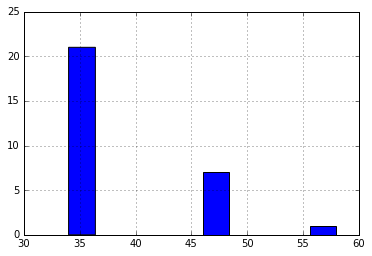

In [18]:
bachelorFemaleStudentsDataFrame['number_months'].hist()

**The mean is at 37.72 months**

In [19]:
bachelorFemaleStudentsDataFrame['number_months'].describe()

count    29.000000
mean     37.724138
std       6.496684
min      34.000000
25%      34.000000
50%      34.000000
75%      46.000000
max      58.000000
Name: number_months, dtype: float64

We can see that most of the male students completed their bachelor in 2 years, and a few did it in 3 years, and some in 70 months.

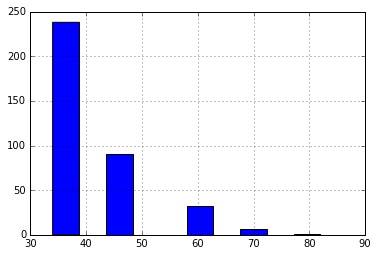

In [20]:
bachelorMaleStudentsDataFrame['number_months'].hist()

**The mean is at 39.77**

In [21]:
bachelorMaleStudentsDataFrame['number_months'].describe()

count    368.000000
mean      39.771739
std        8.943788
min       34.000000
25%       34.000000
50%       34.000000
75%       46.000000
max       82.000000
Name: number_months, dtype: float64

In [23]:
bachelorMaleStudentsDataFrame.loc[bachelorMaleStudentsDataFrame['number_months']==82]

,sex,name,sciper,year_bachelor1,year_bachelor6,number_months
381,Monsieur,Perrin Sami,196034,2009,2015,82


### Statistical tests
"For the number of months between bachelor 1 and 6, is the difference in average statistically significant between male and female students?"

We will perform a Welch’s t-test, because the variance, mean and sample size are different. 
See doc of the function used [here](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)


H0: "Both population have equal mean"
H1: "The means are different"

In [22]:
stats.ttest_ind(bachelorMaleStudentsDataFrame['number_months'], bachelorFemaleStudentsDataFrame['number_months'], equal_var = False)

Ttest_indResult(statistic=1.5831651359439411, pvalue=0.12191236829650394)

With a p-value that is above 0.05 and t-statistic < 1,95, we can not reject H0. 

**Conclusion : there is no significant in the difference in average between male and female students**